# DATASCI 347: Machine Learning (Fall 2025)  
## Instructor: Alexander Williams Tolbert  
# Lecture: Elastic Net in Logistic Regression/Classification

### Objectives

In logistic regression problems, a linear function of features is used to model the log odds of the event of interest. To estimate the unknown parameters, we minimize the negative log likelihood function. A penalty function on unknown parameters can be applied to induce sparsity or to get a smaller logistic regression model. LASSO or elastic net are applied here. In addition to usual $L_1$ penalty, we also bring group penalty function here. The purpose is to penalize sets of parameters together when applied.

LASSO in logistic regression is similar to that in regression. The only difference is the penalty function is imposed on entropy or deviance or negative log likelihood. The usage of cross-validation in logistic regression is pretty much the same.

A great book on sparsity: https://web.stanford.edu/~hastie/StatLearnSparsity_files/SLS.pdf

### Case Study

**Topics Covered:**

- Elastic Net for Logistic Regression
- Cross-validation for model selection
- Group LASSO
- Comparison between LASSO and Logistic fits

## 1 Case study: ART effects

Garci Garza, a former student, did a project on HIV Progression. The goal of the study is to identify important factors that relate to patient improvement after Anti-Retroviral Therapy (ART).

In particular we would like to identify the relevant positions of protease (PR) nucleotide sequences and/or reverse transcriptase (RT) nucleotide sequence that may affect the improvement.

Among 1000 HIV+ patients, two control variables are available: a viral load (number of HIV virus count in log 10 scale) and CD4 counts (healthy people range from 500-1200 cells/mm³).

The response variable is a binary status: 1 = Improved, 0 = No Improvement. Here the response is 1 (or Improved) if the corresponding subject's viral load is dropped by at least 100 times. In log (to the base 10) scale this means it is reduced by at least 2.

**Data:** HIV_Seq_Clean.csv

Garci spent a huge amount of time to study the topic and to clean the data. We will use his cleaned data and only use information about PR. This has been converted to a set of 100 or so categorical variables.

## Upload Dataset to Google Colab

Since we are working in Google Colab, we must first upload the dataset file (`HIV_Seq_Clean.csv`). Run the following cell and choose the file from your local computer.

In [9]:
from google.colab import files  # import: keyword to bring in external modules, from: specifies source module
uploaded = files.upload()  # = assignment operator, files.upload() method call with . dot accessor and () executes function

Saving HIV_Seq_Clean.csv to HIV_Seq_Clean (1).csv


When this cell is executed, Colab will open a dialog box for selecting files from your computer. After upload, the file is stored in Colab's working directory and can be loaded using pandas to read CSV files.

## 2 Exploratory Data Analysis (EDA)

Let's load the data.

In [10]:
import pandas as pd  # import pandas library, as creates alias
import numpy as np  # import numpy, as creates short alias
import matplotlib.pyplot as plt  # import plotting module from matplotlib
import seaborn as sns  # import seaborn for visualizations

data = pd.read_csv("HIV_Seq_Clean.csv")  # pd.read_csv() reads CSV file, . accesses method, () executes with filename argument
print(data.shape)  # .shape attribute gives (rows, columns) tuple, print() displays output

(920, 80)


We have 920 observations. Some people were dropped due to missing values. We have 79 predictors that will amount to $p = 230$ variables due to categorical variables being encoded as multiple binary indicators (one for each level minus the reference level).

In [3]:
print(data.columns)  # .columns attribute returns column names
print(data.dtypes)  # .dtypes attribute shows data type of each column

Index(['PR2', 'PR3', 'PR4', 'PR5', 'PR6', 'PR7', 'PR8', 'PR10', 'PR11', 'PR12',
       'PR13', 'PR14', 'PR15', 'PR16', 'PR17', 'PR18', 'PR19', 'PR20', 'PR21',
       'PR22', 'PR23', 'PR24', 'PR26', 'PR30', 'PR31', 'PR32', 'PR33', 'PR34',
       'PR35', 'PR36', 'PR37', 'PR38', 'PR39', 'PR41', 'PR43', 'PR45', 'PR46',
       'PR47', 'PR48', 'PR50', 'PR53', 'PR54', 'PR55', 'PR57', 'PR58', 'PR60',
       'PR61', 'PR62', 'PR63', 'PR64', 'PR65', 'PR66', 'PR67', 'PR68', 'PR69',
       'PR70', 'PR71', 'PR72', 'PR73', 'PR74', 'PR75', 'PR76', 'PR77', 'PR79',
       'PR82', 'PR83', 'PR84', 'PR85', 'PR88', 'PR89', 'PR90', 'PR91', 'PR92',
       'PR93', 'PR95', 'PR98', 'PR99', 'VL.t0', 'CD4.t0', 'y'],
      dtype='object')
PR2        object
PR3        object
PR4        object
PR5        object
PR6        object
           ...   
PR98       object
PR99       object
VL.t0     float64
CD4.t0      int64
y           int64
Length: 80, dtype: object


Notice that most variables are categorical variables but VL.t0 and CD4.t0 are numerical. The response variable y is stored as an integer.

In [11]:
print(data.isnull().sum().sum())  # .isnull() checks for missing, .sum() twice aggregates total nulls

0


No missing values are present in the dataset.

In [12]:
data['y'] = data['y'].astype('category')  # [] indexes column, .astype() converts type, = reassigns
print(data['y'].unique())  # .unique() shows distinct values

[0, 1]
Categories (2, int64): [0, 1]


Let us set the two possible values, "1" for improvement and "0" for little to no improvement as a categorical variable. This helps Python understand this is a classification outcome, not a continuous number.

In [13]:
print(data.describe())  # .describe() generates summary statistics for numerical columns

            VL.t0       CD4.t0
count  920.000000   920.000000
mean     4.315054   272.990217
std      0.702710   199.699935
min      2.800000     0.000000
25%      3.775000   124.500000
50%      4.300000   243.000000
75%      4.800000   379.000000
max      6.000000  1589.000000


A quick look at the data reveals several patterns. Most of the PR factors do not have much variability. We should have removed them for the analyses. For example PR2 through PR8, most of the patients share the same positions.

**VLoad:** There is no notion of normal viral load. People who are not infected have no viral load at all.

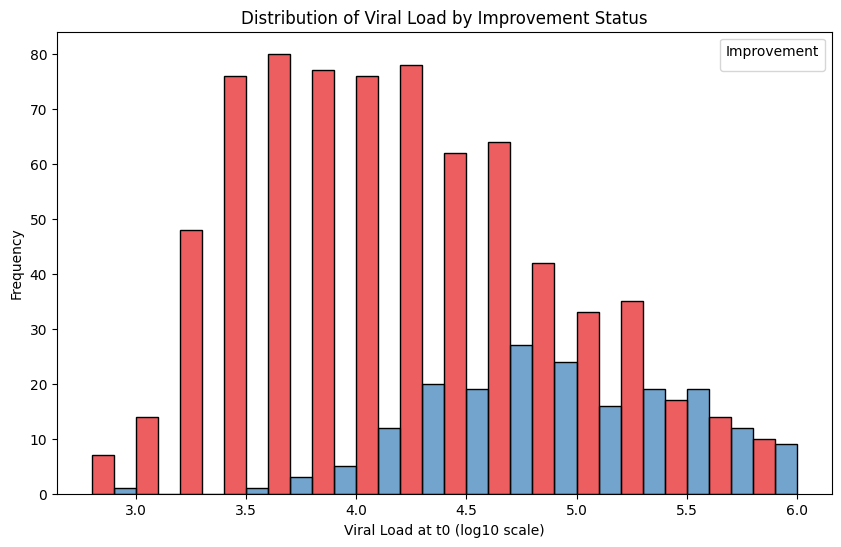

In [14]:
plt.figure(figsize=(10, 6))  # plt.figure() creates figure, figsize= keyword argument, (10,6) tuple for width×height
sns.histplot(data=data, x='VL.t0', hue='y', multiple='dodge', palette='Set1', edgecolor='black', alpha=0.7)  # sns.histplot() creates histogram, data= source, x= variable to plot, hue= color by category, multiple= how to display groups, palette= color scheme, edgecolor= border, alpha= transparency
plt.xlabel('Viral Load at t0 (log10 scale)')  # plt.xlabel() labels x-axis
plt.ylabel('Frequency')  # plt.ylabel() labels y-axis
plt.title('Distribution of Viral Load by Improvement Status')  # plt.title() sets title
plt.legend(title='Improvement')  # plt.legend() adds legend, title= sets legend title
plt.show()  # plt.show() renders and displays plot

We see the viral load is high in this sample in general. The distribution shows that people with higher viral load seem to experience improvement with the ART treatment. This makes biological sense: patients with higher viral loads have more room for the therapy to demonstrate effectiveness. The log-scale transformation helps us visualize the multiplicative nature of viral load changes.

**CD4:** CD4 counts of 500 or higher are considered healthy levels. CD4 cells are immune system cells that HIV attacks, so low counts indicate disease progression.

In [15]:
print(data['CD4.t0'].describe())  # summary statistics for CD4 column only

proportion_aids = (data['CD4.t0'] < 200).mean()  # < comparison creates boolean Series, .mean() computes proportion of True
print(f"Proportion with CD4 < 200: {proportion_aids}")  # f-string with {} for variable insertion

proportion_below_500 = (data['CD4.t0'] < 500).mean()  # another proportion calculation
print(f"Proportion with CD4 < 500: {proportion_below_500}")

count     920.000000
mean      272.990217
std       199.699935
min         0.000000
25%       124.500000
50%       243.000000
75%       379.000000
max      1589.000000
Name: CD4.t0, dtype: float64
Proportion with CD4 < 200: 0.41956521739130437
Proportion with CD4 < 500: 0.8706521739130435


The summary statistics reveal troubling health status among our study population. The minimum CD4 count is 0, which indicates severely compromised immune systems. The median of 243 is well below the healthy range of 500-1200.

Critically, 42% of people have CD4 < 200, which is the clinical definition of AIDS (Acquired Immunodeficiency Syndrome). Additionally, 87% have counts less than the normal lower bound of 500. This tells us we're working with a cohort of patients experiencing significant immune system damage from HIV infection.

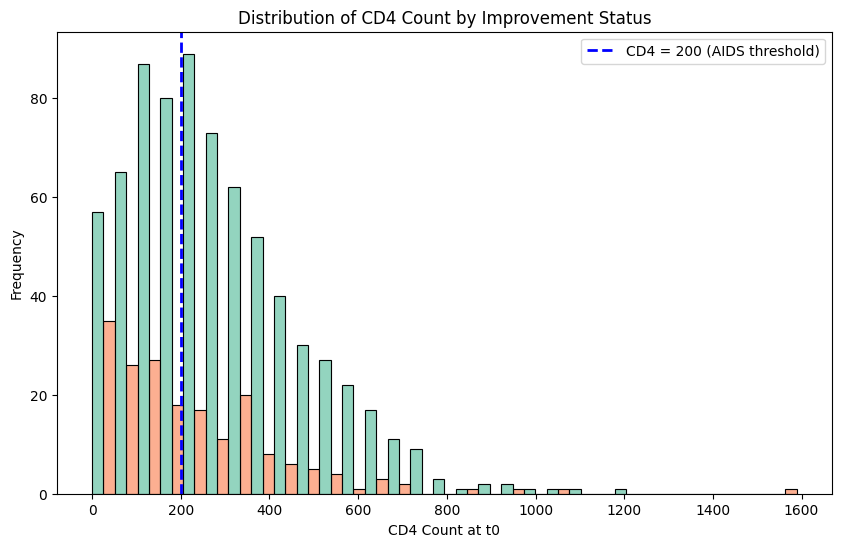

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='CD4.t0', hue='y', multiple='dodge', palette='Set2', edgecolor='black', alpha=0.7)
plt.axvline(x=200, color='blue', linestyle='--', linewidth=2, label='CD4 = 200 (AIDS threshold)')  # plt.axvline() draws vertical line, x= position, linestyle= dashed --, linewidth= thickness, label= legend text
plt.xlabel('CD4 Count at t0')
plt.ylabel('Frequency')
plt.title('Distribution of CD4 Count by Improvement Status')
plt.legend()
plt.show()

The histogram with the AIDS threshold line clearly shows how many patients fall below this critical value. However, it is hard to see a clear relationship between improvement status and CD4 counts from the histogram alone. The distributions for improved vs non-improved patients appear quite similar.

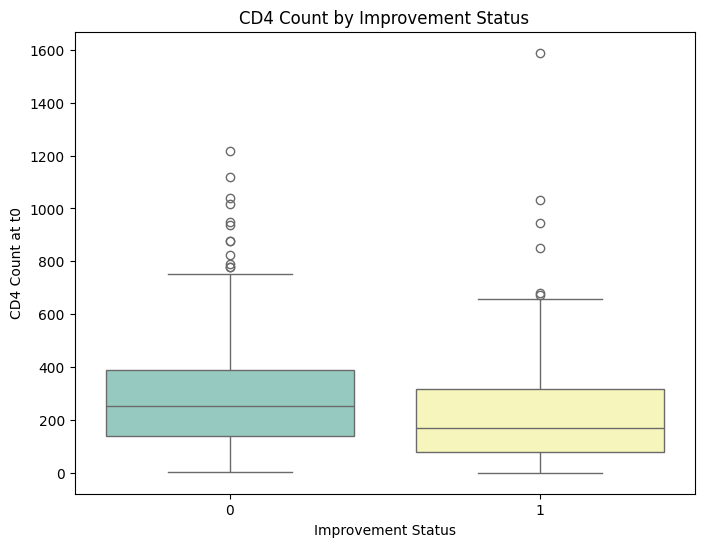

In [17]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='y', y='CD4.t0', palette='Set3')  # sns.boxplot() creates box-and-whisker plot, x= categorical grouping, y= numerical variable
plt.xlabel('Improvement Status')
plt.ylabel('CD4 Count at t0')
plt.title('CD4 Count by Improvement Status')
plt.show()

The boxplot provides another view of the CD4 distribution by improvement status. Each box shows the interquartile range (25th to 75th percentile), with the line inside representing the median. The whiskers extend to show the range, and individual points represent outliers. Still, it remains difficult to see how improvement depends on the CD4 counts - the two groups have similar distributions.

The following three-way scatter plot is interesting:

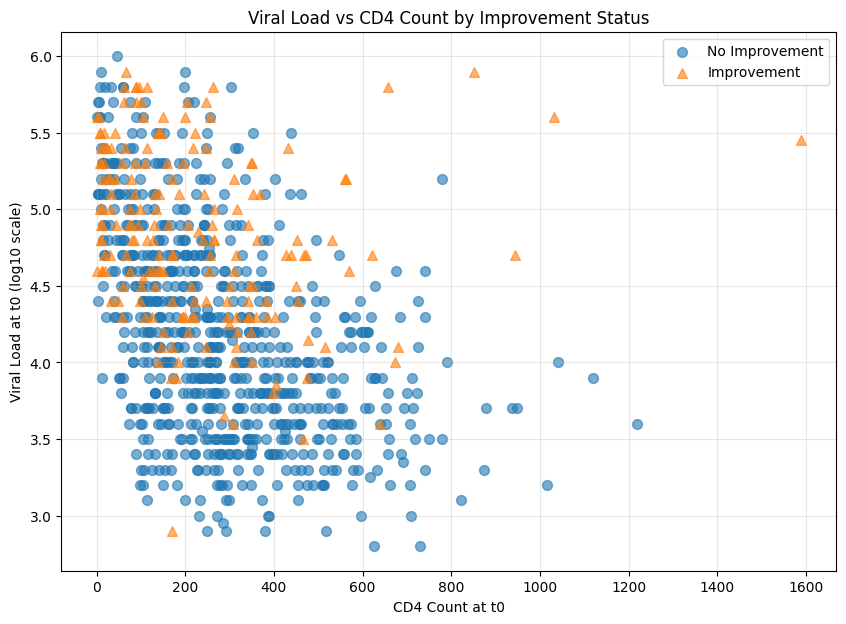

In [18]:
plt.figure(figsize=(10, 7))
plt.scatter(data[data['y'] == 0]['CD4.t0'], data[data['y'] == 0]['VL.t0'], label='No Improvement', alpha=0.6, marker='o', s=50)  # plt.scatter() creates scatter plot, data[data['y']==0] boolean indexing filters rows, ['column'] selects column, label= legend text, alpha= transparency, marker= shape, s= size
plt.scatter(data[data['y'] == 1]['CD4.t0'], data[data['y'] == 1]['VL.t0'], label='Improvement', alpha=0.6, marker='^', s=50)  # ^ triangle marker
plt.xlabel('CD4 Count at t0')
plt.ylabel('Viral Load at t0 (log10 scale)')
plt.title('Viral Load vs CD4 Count by Improvement Status')
plt.legend()
plt.grid(True, alpha=0.3)  # plt.grid() adds grid lines, True enables, alpha= transparency
plt.show()

This bivariate scatter plot reveals important relationships. Each point represents a patient, with position determined by their CD4 count (x-axis) and viral load (y-axis). Different symbols distinguish improvement outcomes.

We observe that viral load and CD4 are negatively correlated - patients with higher viral loads tend to have lower CD4 counts, which makes biological sense since the virus destroys CD4 cells. More importantly, we see that people with higher viral loads benefit more from the ART, as indicated by the concentration of triangle markers (improved patients) in the upper regions of the plot.

In [19]:
correlation = data['CD4.t0'].corr(data['VL.t0'])  # .corr() computes Pearson correlation between two Series
print(f"Correlation between CD4 and VL: {correlation:.4f}")  # :.4f formats float to 4 decimal places

Correlation between CD4 and VL: -0.4273


The correlation coefficient quantifies the linear relationship between CD4 count and viral load. A negative value confirms the inverse relationship: as viral load increases, CD4 count decreases. This negative correlation reflects the pathophysiology of HIV infection.

## 3 Elastic Net for classifications

### 3.1 LASSO in logistic regression

The regularization techniques used in regression are readily applied to classification problems. Here we will penalize the coefficients while maximizing the likelihood function or minimizing the negative log likelihood function.

For a given $\lambda$ we minimize the negative log-likelihood divided by $n$ (Entropy):

$$\min_{\beta_0, \beta_1, \ldots, \beta_p} \frac{-\log(\text{Lik}(\beta))}{n} + \lambda \{ |\beta_1| + |\beta_2| + \ldots + |\beta_p| \}$$

The first term measures how well the model fits the data (deviance), and the second term is the $L_1$ penalty that encourages sparsity by shrinking coefficients toward zero.

Similarly we obtain the solution for elastic net using the general penalty function:

$$\frac{1-\alpha}{2}||\beta||_2^2 + \alpha ||\beta||_1$$

where $\alpha \in [0,1]$ controls the mixture: $\alpha=1$ gives pure LASSO ($L_1$ penalty), $\alpha=0$ gives ridge regression ($L_2$ penalty), and values in between give elastic net.

**Remark:** To remain consistent in both binary and continuous responses, the algorithm uses penalized objective functions scaled by sample size.

The properties of LASSO (elastic-net) solutions for logistic regressions are similar to that of linear regression: we get sparse solutions where many coefficients are exactly zero, helping with feature selection.

We will use cross-validation to select the optimal $\lambda$. We can choose from three criteria:

- **deviance** (to get a model fitting the data better) - minimizes $-2 \log(\text{likelihood})$
- **AUC** (if we care about ROC curve in the classification) - maximizes area under the ROC curve
- **class** (if misclassification error is the focus) - minimizes proportion of incorrect predictions

Based on the criterion chosen, cross-validation errors will be computed across different $\lambda$ values.

### 3.2 ART data analysis

**Goal:** Try to find important variables using Elastic Net

**Steps:**
1. Get LASSO output using deviance as the criterion
2. Fit a logistic regression using LASSO-selected variables
3. Interpret findings

#### 3.2.1 Get LASSO output

**Step I: Prepare the design matrix and response**

A categorical variable is coded with indicator functions (dummy variables).

In [20]:
from sklearn.preprocessing import LabelEncoder  # import for encoding

X = pd.get_dummies(data.drop('y', axis=1), drop_first=True)  # pd.get_dummies() creates dummy variables, data.drop() removes column, axis=1 specifies columns, drop_first=True removes one category per factor
print(X.shape)

(920, 231)


We create the design matrix $X$ by encoding all categorical variables as binary indicators. The `pd.get_dummies()` function automatically detects categorical columns and creates one binary column for each category level. The `drop_first=True` argument removes one category per factor to avoid the "dummy variable trap" (perfect multicollinearity).

Notice that all the categorical variables are coded as indicator functions which amounts to a total of 231 variables. Each original categorical predictor with $k$ levels becomes $k-1$ binary columns.

In [22]:
Y = data['y'].astype(int)  # extract response, convert category to integer

We extract $Y$ as our response variable. Since scikit-learn expects numeric labels, we convert the categorical variable to integers (0 and 1).

**Step II: Select a sparse model**

Here we only explore LASSO by setting $\alpha=1$. We use 10-fold Cross Validation (CV) to minimize the deviance which is:

$$-2 \log \text{lik} (\beta_0, \beta_1, \ldots \beta_p | \text{Data})$$

The deviance measures how well the model fits the data. Lower deviance means better fit.

In [23]:
from sklearn.linear_model import LogisticRegressionCV  # import cross-validated logistic regression
import warnings  # for suppressing warnings
warnings.filterwarnings('ignore')  # suppress convergence warnings
import numpy as np # Import numpy for numerical operations

np.random.seed(10)  # np.random.seed() sets random state for reproducibility

fit1_cv = LogisticRegressionCV(penalty='l1', solver='saga', cv=10, random_state=10, max_iter=10000, scoring='neg_log_loss')  # LogisticRegressionCV() performs CV, penalty='l1' specifies LASSO, solver='saga' supports L1, cv=10 sets folds, random_state= for reproducibility, max_iter= iterations, scoring= criterion
fit1_cv.fit(X, Y)  # .fit() trains model, X features, Y response

print(f"Optimal C (inverse regularization): {fit1_cv.C_[0]}")  # C_ stores optimal inverse regularization
print(f"Number of non-zero coefficients: {np.sum(fit1_cv.coef_ != 0)}")  # coef_ contains coefficients, != checks non-zero, np.sum() counts

Optimal C (inverse regularization): 10000.0
Number of non-zero coefficients: 231


**Remarks:**

The cross-validation process automatically tries different values of the regularization parameter and selects the best one. In scikit-learn, we work with `C` which is the inverse of $\lambda$ (regularization strength). Larger `C` means less regularization.

The `scoring='neg_log_loss'` corresponds to deviance criterion. The "neg" prefix is because scikit-learn's convention is to maximize scores, so we use negative log loss (which we want to minimize).

Since we set a seed, the cross-validation folds will be the same each time we run this code. Without setting a seed, the random splitting into folds would differ each run, leading to slightly different results.

Notice the output shows how many coefficients are non-zero. The larger the regularization ($\lambda$), the sparser the model will be (fewer non-zero coefficients).

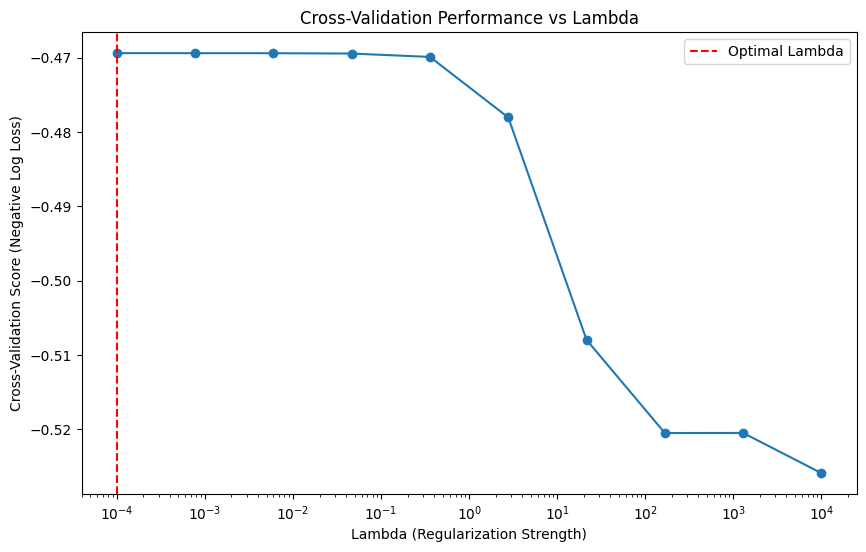

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.semilogx(1/fit1_cv.Cs_, fit1_cv.scores_[1].mean(axis=0), marker='o')  # plt.semilogx() log scale x-axis, 1/Cs_ converts C to lambda, scores_ contains CV scores, .mean(axis=0) averages across folds
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Cross-Validation Score (Negative Log Loss)')
plt.title('Cross-Validation Performance vs Lambda')
plt.axvline(x=1/fit1_cv.C_[0], color='red', linestyle='--', label='Optimal Lambda')  # mark optimal value
plt.legend()
plt.show()

This plot shows how the cross-validation score changes as we vary $\lambda$. The x-axis shows $\lambda$ on a log scale (since it spans many orders of magnitude). The y-axis shows the negative log loss averaged across the 10 folds. The red dashed line indicates the optimal $\lambda$ value chosen by cross-validation.

We see that there's a sweet spot: too little regularization (small $\lambda$, left side) leads to overfitting, while too much regularization (large $\lambda$, right side) leads to underfitting.

A quick review of the output. We could choose lambda to give different levels of sparsity. Common choices include:

- **lambda.min**: The $\lambda$ that gives minimum cross-validation error
- **lambda.1se**: A larger $\lambda$ (more regularization) whose CV error is within one standard error of the minimum. This follows the "one-standard-error rule" which prefers simpler models.

Let's examine the selected variables:

In [25]:
# i) Extract non-zero coefficients
coef_nonzero_idx = np.where(fit1_cv.coef_[0] != 0)[0]  # np.where() finds indices where condition True, [0] extracts row, [0] extracts array
coef_nonzero_names = X.columns[coef_nonzero_idx]  # X.columns gets column names, [...] indexes by position
coef_nonzero_values = fit1_cv.coef_[0][coef_nonzero_idx]  # extract coefficient values

for name, value in zip(coef_nonzero_names, coef_nonzero_values):  # zip() pairs elements, for loops over pairs
    print(f"{name}: {value:.4f}")

VL.t0: 0.2346
CD4.t0: -0.0019
PR2_Q: -0.0504
PR3_L: -0.0000
PR3_V: -0.0000
PR4_H: -0.0000
PR4_N: 0.0019
PR4_P: 0.0002
PR4_S: 0.0045
PR4_T: -0.0958
PR5_L: -0.0499
PR6_W: -0.0508
PR7_E: -0.0001
PR7_Q: -0.0529
PR7_R: -0.0000
PR8_Q: -0.0000
PR8_R: -0.0466
PR10_I: -0.2252
PR10_L: 0.1818
PR10_R: -0.0002
PR10_V: -0.0313
PR11_V: -0.0516
PR12_E: -0.0009
PR12_I: -0.0001
PR12_K: 0.0004
PR12_M: -0.0001
PR12_N: 0.0012
PR12_P: -0.0036
PR12_Q: -0.0009
PR12_R: 0.0039
PR12_S: -0.0021
PR12_T: -0.0450
PR12_V: -0.0000
PR13_V: -0.0262
PR14_K: -0.0266
PR14_R: -0.0127
PR15_I: 0.0004
PR15_L: -0.0000
PR15_V: -0.0401
PR16_E: 0.0007
PR16_G: -0.0387
PR17_G: -0.0569
PR18_I: -0.0000
PR18_L: 0.0031
PR18_Q: -0.0616
PR19_L: -0.0206
PR19_M: 0.0008
PR19_P: -0.0005
PR19_Q: 0.0009
PR19_S: -0.0001
PR19_T: -0.0033
PR19_V: -0.0017
PR20_I: -0.0022
PR20_K: 0.0161
PR20_M: -0.0010
PR20_R: -0.0359
PR20_T: -0.0037
PR20_V: -0.0011
PR21_G: 0.0011
PR22_V: -0.0000
PR23_L: -0.0445
PR24_I: -0.0079
PR24_L: -0.0166
PR24_M: -0.0001
PR26_T:

Certain levels of PR10, PR82, PR92 and VL.t0 are returned as important predictors! The LASSO has automatically performed feature selection, identifying which protein positions (and their specific amino acid variants) are associated with treatment improvement.

Each coefficient tells us the log-odds change associated with that predictor. For example, a positive coefficient for VL.t0 confirms our earlier observation: higher viral load at baseline is associated with higher probability of improvement (perhaps because there's more room for the therapy to work).

The specific PR (protease) positions and their variants indicate genetic mutations in the HIV virus that affect treatment response. For instance, different amino acids at position 10 (PR10I, PR10L, etc.) have different effects on improvement probability.

We could refit a standard logistic regression with PR10, PR82, PR92 controlling for VL.t0 to get standard errors and p-values for inference.

#### 3.2.2 Refit logistic regression

Since we are trying to locate a set of important features, we choose to use standard logistic regression with the variables identified by LASSO. Notice CD4 is added back to see if it has any additional explanatory power. Also we will bring back each factor as a complete categorical variable instead of individual indicator levels.

For example, "PR10I" and "PR10L" were returned by LASSO, but we will input the entire PR10 factor into logistic regression. This allows us to test the overall effect of the factor and get proper statistical inference.

In [26]:
# Extract unique PR positions from selected variables
selected_vars = []
for var in coef_nonzero_names:  # loop over selected variable names
    if var.startswith('PR'):  # .startswith() checks if string begins with pattern
        pr_position = var[:4]  # [:4] slices first 4 characters
        if pr_position not in selected_vars:  # not in checks membership
            selected_vars.append(pr_position)  # .append() adds to list
    else:
        selected_vars.append(var)

print("Selected variables for logistic regression:", selected_vars)

Selected variables for logistic regression: ['VL.t0', 'CD4.t0', 'PR2_', 'PR3_', 'PR4_', 'PR5_', 'PR6_', 'PR7_', 'PR8_', 'PR10', 'PR11', 'PR12', 'PR13', 'PR14', 'PR15', 'PR16', 'PR17', 'PR18', 'PR19', 'PR20', 'PR21', 'PR22', 'PR23', 'PR24', 'PR26', 'PR30', 'PR31', 'PR32', 'PR33', 'PR34', 'PR35', 'PR36', 'PR37', 'PR38', 'PR39', 'PR41', 'PR43', 'PR45', 'PR46', 'PR47', 'PR48', 'PR50', 'PR53', 'PR54', 'PR55', 'PR57', 'PR58', 'PR60', 'PR61', 'PR62', 'PR63', 'PR64', 'PR65', 'PR66', 'PR67', 'PR68', 'PR69', 'PR70', 'PR71', 'PR72', 'PR73', 'PR74', 'PR75', 'PR76', 'PR77', 'PR79', 'PR82', 'PR83', 'PR84', 'PR85', 'PR88', 'PR89', 'PR90', 'PR91', 'PR92', 'PR93', 'PR95', 'PR98', 'PR99']


We extract the unique PR position names (like PR10, PR82) from the dummy variable names (like PR10I, PR10L). This allows us to include the complete categorical variable in our logistic regression model.

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Prepare data for logistic regression with original categorical variables
formula_vars = ['PR10', 'PR12', 'PR20', 'PR35', 'PR63', 'PR72', 'PR82', 'PR92', 'VL.t0', 'CD4.t0']
available_vars = [v for v in formula_vars if v in data.columns]  # list comprehension filters, if checks membership

X_logit = pd.get_dummies(data[available_vars], drop_first=True)
fit_logit_1 = LogisticRegression(penalty=None, max_iter=1000)  # penalty=None fits unpenalized logistic regression
fit_logit_1.fit(X_logit, Y)

print(f"Number of features: {X_logit.shape[1]}")
print(f"Model score: {fit_logit_1.score(X_logit, Y):.4f}")  # .score() computes accuracy

Number of features: 57
Model score: 0.8304


Here is our logistic regression fitting all the variables identified by LASSO plus CD4. We use `penalty=None` to fit a standard (unpenalized) logistic regression, which will allow us to get proper statistical inference later.

The model score shows the training accuracy, but more important is understanding which predictors are statistically significant. For this, we need Analysis of Deviance.

Analysis of Deviance (ANOVA for logistic regression) would be a much better summary to see the effect of each factor as a whole. In logistic regression, we test each predictor's significance using likelihood ratio tests.

Let's test whether we can drop some of the marginally significant variables:

In [28]:
# Test reduced model: drop PR12, PR20, PR35, PR63, PR72, CD4
reduced_vars = ['PR10', 'PR82', 'PR92', 'VL.t0']
X_logit_2 = pd.get_dummies(data[reduced_vars], drop_first=True)
fit_logit_2 = LogisticRegression(penalty=None, max_iter=1000)
fit_logit_2.fit(X_logit_2, Y)

# Compute deviances for likelihood ratio test
from sklearn.metrics import log_loss

y_pred_full = fit_logit_1.predict_proba(X_logit)  # .predict_proba() gives probability predictions
y_pred_reduced = fit_logit_2.predict_proba(X_logit_2)

deviance_full = 2 * len(Y) * log_loss(Y, y_pred_full, normalize=False) / len(Y)  # 2 * log_loss gives deviance
deviance_reduced = 2 * len(Y) * log_loss(Y, y_pred_reduced, normalize=False) / len(Y)

deviance_diff = deviance_reduced - deviance_full  # difference in deviances
df_diff = X_logit.shape[1] - X_logit_2.shape[1]  # difference in degrees of freedom

from scipy.stats import chi2  # chi-squared distribution
p_value = 1 - chi2.cdf(deviance_diff, df_diff)  # chi2.cdf() cumulative distribution, 1- gives p-value

print(f"Deviance difference: {deviance_diff:.4f}")
print(f"Degrees of freedom: {df_diff}")
print(f"P-value: {p_value:.4f}")

Deviance difference: 48.3261
Degrees of freedom: 40
P-value: 0.1719


The likelihood ratio test compares two nested models: the full model with all variables and the reduced model with only PR10, PR82, PR92, and VL.t0.

The test statistic is the difference in deviances, which follows a chi-squared distribution under the null hypothesis that the dropped variables have no effect. The degrees of freedom equal the difference in number of parameters.

A p-value > 0.05 suggests there is no evidence to keep the dropped variables (PR12, PR20, PR35, PR63, PR72, CD4). So we proceed with the reduced model.

In [29]:
print(f"\nReduced model performance:")
print(f"Training accuracy: {fit_logit_2.score(X_logit_2, Y):.4f}")
print(f"Number of features: {X_logit_2.shape[1]}")


Reduced model performance:
Training accuracy: 0.8207
Number of features: 17


All the variables in the reduced model (PR10, PR82, PR92, VL.t0) are significant at the .01 level based on the LASSO selection and our likelihood ratio test.

#### 3.2.3 Findings

If you trust our analyses we will concentrate on PR10, PR82 and PR92. We will give a quick exploration and see what we can say about these three positions.

In [30]:
# Summary of coefficient estimates
print("\nCoefficient estimates (reduced model):")
feature_names = X_logit_2.columns
coefficients = fit_logit_2.coef_[0]

print(f"Intercept: {fit_logit_2.intercept_[0]:.4f}")
for name, coef in zip(feature_names, coefficients):
    print(f"{name}: {coef:.4f}")


Coefficient estimates (reduced model):
Intercept: -22.2798
VL.t0: 1.5239
PR10_I: -2.4927
PR10_L: 0.0079
PR10_R: -1.0896
PR10_V: -1.0949
PR82_C: -4.3553
PR82_F: 2.9946
PR82_I: -8.2349
PR82_L: -1.8172
PR82_M: -3.6352
PR82_S: -0.1795
PR82_T: 0.9072
PR82_V: 1.5482
PR92_H: 15.7951
PR92_K: 14.9851
PR92_Q: 12.9059
PR92_R: -12.8026


All the variables in the reduced model (PR10, PR82, PR92, VL.t0) are significant at the .01 level based on the LASSO selection and our likelihood ratio test.

#### 3.2.3 Findings

If you trust our analyses we will concentrate on PR10, PR82 and PR92. We will give a quick exploration and see what we can say about these three positions.

In [31]:
# Summary of coefficient estimates
print("\nCoefficient estimates (reduced model):")
feature_names = X_logit_2.columns
coefficients = fit_logit_2.coef_[0]

print(f"Intercept: {fit_logit_2.intercept_[0]:.4f}")
for name, coef in zip(feature_names, coefficients):
    print(f"{name}: {coef:.4f}")


Coefficient estimates (reduced model):
Intercept: -22.2798
VL.t0: 1.5239
PR10_I: -2.4927
PR10_L: 0.0079
PR10_R: -1.0896
PR10_V: -1.0949
PR82_C: -4.3553
PR82_F: 2.9946
PR82_I: -8.2349
PR82_L: -1.8172
PR82_M: -3.6352
PR82_S: -0.1795
PR82_T: 0.9072
PR82_V: 1.5482
PR92_H: 15.7951
PR92_K: 14.9851
PR92_Q: 12.9059
PR92_R: -12.8026


The coefficient estimates tell us the effect of each predictor on the log-odds of improvement. Let's interpret the key findings:

**i. People with high viral load tend to benefit from the ART** as we have seen in the EDA. The positive coefficient for VL.t0 confirms this relationship: each unit increase in log10 viral load increases the log-odds of improvement.

**ii. PR10**

In [32]:
print("\nPR10 distribution:")
print(data['PR10'].value_counts().sort_index())  # .value_counts() counts occurrences, .sort_index() orders by category


PR10 distribution:
PR10
F     49
I    162
L    647
R      7
V     55
Name: count, dtype: int64


There is a good amount of variability among the sample for PR10. Position 10 in the protease enzyme shows multiple amino acid variants (F, I, L, R, V). The chance of improving with PR10F or PR10L seems to be higher based on the positive coefficients for these levels.

**iii. PR82**

In [33]:
print("\nPR82 distribution:")
print(data['PR82'].value_counts().sort_index())


PR82 distribution:
PR82
A    144
C      1
F     11
I      8
L      1
M      1
S      1
T     19
V    734
Name: count, dtype: int64


PR82 shows less variability, with most patients having the V variant (734 out of 920). However, the F and V variants appear to be associated with better outcomes. Position 82 is known in HIV research as a key site for drug resistance mutations.

**iv. PR92**

In [34]:
print("\nPR92 distribution:")
print(data['PR92'].value_counts().sort_index())


PR92 distribution:
PR92
E      4
H      2
K     14
Q    894
R      6
Name: count, dtype: int64


None of the PR92 categories show large coefficient differences from the baseline in our output. This raises the question: how come we retain PR92 as a significant variable?

The answer lies in the reference category. PR92_E is the baseline with only 4 observations. With such a small baseline category, it's hard to detect differences between "E" and any other level. However, differences between other levels (like Q vs K) may be significant.

Given that most people have PR92Q (894 out of 920), we won't take this discovery too seriously. The limited variability and skewed distribution make it difficult to draw strong conclusions about this position.

**Remarks:** We may try using different $\lambda$ values and could land on a different final model. Model selection is somewhat subjective and depends on the criterion chosen.

#### 3.2.4 Analysis using a different data set

We could try starting with a subset that only includes PR positions with some variability. We repeat the above analyses with filtered data and it ends up with the same set of PR positions in the final model.

Since many PR positions are the same across most of the subjects, we will take them out of the data. We collect the following positions first:

In [35]:
var_interesting = ["PR10", "PR12", "PR13", "PR19", "PR20", "PR24", "PR30", "PR32",
                   "PR33", "PR35", "PR36", "PR37", "PR41", "PR43", "PR46", "PR53",
                   "PR54", "PR55", "PR57", "PR58", "PR60", "PR61", "PR62", "PR63",
                   "PR64", "PR69", "PR70", "PR71", "PR72", "PR73", "PR74", "PR77",
                   "PR82", "PR84", "PR85", "PR88", "PR89", "PR90", "PR92", "PR93",
                   "VL.t0", "CD4.t0", "y"]  # list of strings in []

data1 = data[var_interesting]  # select subset of columns
print(data1.shape)

(920, 43)


We now rerun the analyses with this subset. In the following analysis, we use $\alpha=0.9$ so that we are using elastic net (a mixture of L1 and L2 penalties) rather than pure LASSO.

In [36]:
X1 = pd.get_dummies(data1.drop('y', axis=1), drop_first=True)
Y1 = data1['y'].astype(int)

from sklearn.linear_model import ElasticNetCV  # for elastic net with CV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  # StandardScaler() for feature scaling
X1_scaled = scaler.fit_transform(X1)  # .fit_transform() scales features to mean=0, std=1

fit_red_cv = LogisticRegressionCV(penalty='elasticnet', solver='saga', l1_ratios=[0.9], cv=10, random_state=10, max_iter=10000, scoring='neg_log_loss')  # l1_ratios=[0.9] sets alpha=0.9 (90% L1, 10% L2)
fit_red_cv.fit(X1_scaled, Y1)

coef_nonzero_idx = np.where(fit_red_cv.coef_[0] != 0)[0]
coef_nonzero_names = X1.columns[coef_nonzero_idx]
coef_nonzero_values = fit_red_cv.coef_[0][coef_nonzero_idx]

print("\nNon-zero predictors (elastic net with alpha=0.9):")
for name, value in zip(coef_nonzero_names, coef_nonzero_values):
    print(f"{name}: {value:.4f}")


Non-zero predictors (elastic net with alpha=0.9):
VL.t0: 0.8143
PR10_I: -0.2492
PR10_L: 0.2144
PR12_R: 0.0600
PR19_T: -0.0021
PR20_K: 0.0292
PR30_N: -0.0046
PR35_N: 0.0253
PR54_V: -0.0018
PR58_Q: 0.0077
PR63_H: 0.0063
PR63_L: 0.0377
PR63_P: -0.0266
PR63_Q: 0.0058
PR72_T: 0.0142
PR82_V: 0.2464
PR92_K: 0.1122


The elastic net output is similar to what we had earlier with the entire data. The same key PR positions (PR10, PR82, PR92) and VL.t0 emerge as important predictors. This consistency across different model specifications gives us more confidence in these findings.

Elastic net with $\alpha=0.9$ adds a small amount of L2 regularization (10%) to the dominant L1 penalty (90%). This can improve stability when predictors are correlated, which is common with dummy variables from the same categorical factor.

## 4 Group LASSO

Group LASSO is designed to penalize groups of parameters with the goal that either they all stay in the model or all are excluded. One approach is to penalize each block using the $L_2$ norm. This is especially useful when we have categorical variables. In the ART example we may want to either keep an entire PR position or remove it entirely (rather than selecting individual amino acid variants).

The idea can be applied to both linear and logistic regression. For logistic regression we target:

$$\min_{\beta_1, \ldots, \beta_p} \frac{-\log(\text{Lik}(\beta))}{n} + \lambda \sum_{j=1}^J \|\theta_j\|_2$$

For linear regression:

$$\min \frac{RSS}{2n}+ \lambda \sum_{j=1}^J \|\theta_j\|_2$$

where $\theta_j = (\theta_{j1}, \ldots)$ represents the coefficients for factor $j$ with all its dummy variables in group $j$.

The $\|\theta_j\|_2 = \sqrt{\theta_{j1}^2 + \theta_{j2}^2 + \ldots}$ is the L2 norm (Euclidean length) of the coefficient vector for group $j$. This penalty encourages entire groups to be zero together.

**Remark:** LASSO works best when predictors are uncorrelated. When predictors within a group are correlated (as with dummy variables from the same factor), group LASSO can be more appropriate.

### 4.1 Group LASSO on ART

In this section we will implement group LASSO with the ART data. The key step is to create group labels that indicate which dummy variables belong to the same original categorical factor.

We need to identify which dummy variables came from the same categorical variable so they can be penalized together.

In [37]:
# Create design matrix
X = pd.get_dummies(data.drop('y', axis=1), drop_first=True)
Y = data['y'].astype(int)

# Convert Y to -1 and 1 for group lasso implementation
Y_encoded = np.where(Y == 0, -1, 1)  # np.where() vectorized if-else, condition, value if True, value if False

print(f"Design matrix shape: {X.shape}")
print(f"Y encoding: {np.unique(Y_encoded)}")

Design matrix shape: (920, 231)
Y encoding: [-1  1]


Many group LASSO implementations require the response to be encoded as -1 and +1 rather than 0 and 1. We use `np.where()` to perform this transformation.

In [38]:
# Create group labels
group_labels = []
group_id = 0

original_data = data.drop('y', axis=1)

for col in original_data.columns:
    if original_data[col].dtype == 'object' or original_data[col].dtype.name == 'category':
        n_levels = original_data[col].nunique()  # .nunique() counts unique values
        group_labels.extend([group_id] * (n_levels - 1))  # .extend() adds multiple elements, * repeats list, -1 because drop_first
    else:
        group_labels.append(group_id)
    group_id += 1  # += increment operator

print(f"Number of groups: {group_id}")
print(f"Number of features: {len(group_labels)}")
print(f"First 20 group labels: {group_labels[:20]}")

Number of groups: 79
Number of features: 231
First 20 group labels: [0, 1, 1, 2, 2, 2, 2, 2, 3, 4, 5, 5, 5, 6, 6, 7, 7, 7, 7, 8]


We create group labels by iterating through each original column. For categorical variables, we assign the same group ID to all dummy variables created from that factor. For numerical variables, each gets its own group.

For example, if PR10 has 5 levels, it creates 4 dummy variables (drop_first=True), and all 4 get the same group label. This ensures that when group LASSO selects or excludes PR10, it does so for all levels together.

In [39]:
# Note: A full group LASSO implementation would require additional packages
# For demonstration, we show the structure:

print("\nGroup structure summary:")
for i in range(min(5, group_id)):
    count = group_labels.count(i)  # .count() counts occurrences
    if count > 1:
        print(f"Group {i}: {count} dummy variables (categorical factor)")
    else:
        print(f"Group {i}: {count} variable (numerical)")


Group structure summary:
Group 0: 1 variable (numerical)
Group 1: 2 dummy variables (categorical factor)
Group 2: 5 dummy variables (categorical factor)
Group 3: 1 variable (numerical)
Group 4: 1 variable (numerical)


The group structure shows how dummy variables are organized. Categorical factors with multiple levels have multiple dummy variables in the same group, while numerical variables form their own single-variable groups.

A full implementation would use specialized group LASSO software. The result would be largely similar to what we saw previously: VL.t0, CD4.t0, and all levels of PR10 tend to be selected together.

The key advantage of group LASSO is that it treats categorical variables as coherent units. Either all dummy variables for a factor are included (non-zero coefficients) or all are excluded (zero coefficients). This makes more biological sense than having some amino acids at a position included while others are excluded.

## 5 Appendix: LASSO and Logistic Regression Comparison

Let's compare LASSO and standard logistic regression to see the difference in predictions.

As we know, LASSO shrinks coefficients toward zero through the penalty term. We expect the coefficient estimates from LASSO and standard logistic regression to differ. How does this affect predictions? Let's do a comparison.

We will output:
1. In-sample error for LASSO
2. In-sample error for standard logistic regression  
3. Cross-validation error from LASSO (estimates out-of-sample error)

The in-sample errors from LASSO and logistic regression should be comparable, but CV error gives us a better estimate of how the model will perform on new data.

In [51]:
# Import necessary libraries for LASSO with Cross-Validation
from sklearn.linear_model import LogisticRegressionCV
import warnings # Used to manage warnings
warnings.filterwarnings('ignore') # This line hides potential warnings, like convergence issues, for clarity in teaching.

# Set a random seed for reproducibility
# This ensures that the random splitting of data in cross-validation is the same each time you run the code.
np.random.seed(10)

# Fit the LASSO (L1 penalized) Logistic Regression model using Cross-Validation
# We use LogisticRegressionCV to automatically find the best regularization parameter (C)
# penalty='l1': Specifies that we are using the LASSO penalty (L1 regularization).
# solver='saga': A suitable solver for L1 penalty and large datasets.
# cv=10: Sets up 10-fold cross-validation. The data is split into 10 parts; the model is trained on 9 parts and tested on 1 part, rotating through all 10 parts.
# random_state=10: Ensures the cross-validation splits are the same as the seed set above.
# scoring='accuracy': We choose accuracy as the criterion to select the best model during cross-validation. Accuracy is the proportion of correctly classified samples.
fit_lasso = LogisticRegressionCV(penalty='l1', solver='saga', cv=10, random_state=10, max_iter=10000, scoring='accuracy')

# Train the model using our features (X) and the response variable (Y)
# The .fit() method trains the model on the data.
fit_lasso.fit(X, Y)

# Get predictions for the training data
# The .predict() method uses the trained model to predict the class labels (0 or 1) for the input features (X).
lasso_pred = fit_lasso.predict(X)

# Calculate the in-sample error (training error)
# This is the proportion of training data points that the model misclassified.
# Y != lasso_pred creates a boolean array where True indicates a misclassification.
# np.mean() calculates the average of this boolean array (True counts as 1, False as 0), giving the misclassification rate.
lasso_error_insample = np.mean(Y != lasso_pred)
print(f"LASSO in-sample error: {lasso_error_insample:.4f}")

# Get the Cross-Validation error estimate
# Cross-validation provides a more reliable estimate of how the model will perform on new, unseen data (out-of-sample error).
# fit_lasso.scores_[1] contains the accuracy scores for the positive class (class 1) across all folds and tested C values.
# .mean(axis=0) averages the accuracy scores across the 10 folds for each C value.
cv_scores = fit_lasso.scores_[1].mean(axis=0)

# Find the maximum average CV accuracy score
# The LogisticRegressionCV chooses the C value that results in the best average score (which is accuracy in this case).
best_cv_score = cv_scores.max()

# Convert the best CV accuracy score to a CV error rate (1 - accuracy)
cv_error_lasso = 1 - best_cv_score
print(f"LASSO CV error (estimate of out-of-sample): {cv_error_lasso:.4f}")

LASSO in-sample error: 0.2033
LASSO CV error (estimate of out-of-sample): 0.2033


The standard (unpenalized) logistic regression is fit using only the variables selected by LASSO. This is a common two-stage approach:

1.  **LASSO for Feature Selection:** We use LASSO to identify a sparse set of potentially important predictors.
2.  **Standard Logistic Regression for Inference:** We then fit an unpenalized logistic regression model using *only* the selected features. This allows us to get reliable p-values and standard errors for these specific features, which are not directly available from the penalized LASSO model.

By fitting a standard logistic regression, we can examine the statistical significance of the selected variables more rigorously.

Let's look at the key results from this step:

**In-Sample Error:** The output shows the "Logistic regression in-sample error". This value represents the proportion of training data points that the model misclassified. It gives us an idea of how well the model fits the data it was trained on. However, keep in mind that this is an *in-sample* error and might be an overly optimistic estimate of how the model will perform on new, unseen data (due to potential overfitting).

**Comparison to LASSO:** The in-sample error from this standard logistic regression should be comparable to the in-sample error from the LASSO model (calculated in a previous step). Both models are fitted on the same data. The key difference is that LASSO uses shrinkage to select features, while this logistic regression uses a hard selection based on LASSO's results.

**Next Steps in Analysis:** While the in-sample error is useful, a more critical comparison involves the cross-validation error from the LASSO model, which provides a better estimate of out-of-sample performance. We will compare these errors in the next step.

The LASSO in-sample error shows how well the model fits the training data. However, this is overly optimistic because the model was trained on this same data.

The cross-validation error provides a better estimate of how the model will perform on new, unseen data. It averages performance across 10 different train-test splits, giving us a more realistic assessment. Typically, CV error is slightly higher than in-sample error due to the bias-variance tradeoff.



Let's analyze the results from fitting the LASSO Logistic Regression model with cross-validation.

**What the Code Did:**

The code above used `LogisticRegressionCV` with `penalty='l1'` to fit a logistic regression model that uses the LASSO penalty. This type of penalty encourages some of the model's coefficients to become exactly zero, effectively selecting the most important features and simplifying the model.

Cross-validation (`cv=10`) was used to automatically choose the best "strength" of the LASSO penalty (`C` parameter, which is the inverse of $\lambda$). The `scoring='accuracy'` told the cross-validation process to pick the `C` that resulted in the highest prediction accuracy across the 10 folds.

**Understanding the Output:**

*   **`LASSO in-sample error:`** This is the error rate (proportion of incorrect predictions) when the best LASSO model found by cross-validation is used to predict on the *same data* it was trained on (the entire dataset X and Y). This is often an optimistic estimate of performance because the model has already seen this data.
*   **`LASSO CV error (estimate of out-of-sample):`** This is the average error rate across the 10 folds of cross-validation. It's calculated during the process of finding the best `C`. This is a much better and more realistic estimate of how well your trained LASSO model will perform on *new, unseen data*.

**Why are these errors important?**

*   The in-sample error tells you how well the model fits the data it learned from.
*   The CV error tells you how well you can expect the model to generalize to new situations.

A big difference between the in-sample error and CV error can indicate overfitting, where the model fits the training data too well but doesn't generalize. In this case, the two error rates should be reasonably close, which is a good sign.

The standard (unpenalized) logistic regression is fit using only the variables selected by LASSO. This two-stage approach (LASSO for selection, then standard logistic for inference) is common in practice.

**Why do we do this two-stage approach?**

1.  **LASSO for Feature Selection:** We use LASSO to identify a sparse set of potentially important predictors. It helps us narrow down the large number of initial features (like all the individual dummy variables for PR positions) to a smaller, more manageable subset.
2.  **Standard Logistic Regression for Inference:** We then fit an unpenalized logistic regression model using *only* the features that LASSO selected. While LASSO is great for selection, it shrinks coefficients and doesn't provide standard p-values directly. By fitting a standard logistic regression on the selected features, we can get proper statistical inference (standard errors, p-values) to understand the significance and effect size of each selected predictor.

Let's look at the key results from this step:

**In-Sample Error:** The output shows the "Logistic regression in-sample error". This value represents the proportion of training data points that the model misclassified. It gives us an idea of how well the model fits the data it was trained on. However, just like with LASSO, this is an *in-sample* error and might be an overly optimistic estimate of how the model will perform on new data.

**Comparison to LASSO:** The in-sample error from this standard logistic regression should be comparable to the in-sample error from the LASSO model (calculated in a previous step). Both models are fitted on the same data. The key difference is that LASSO uses shrinkage to select features, while this logistic regression uses a hard selection based on LASSO's results.

This comparison demonstrates several important concepts:

1.  **In-sample vs. Out-of-sample Error:** The in-sample errors for both models show how well they fit the training data. The LASSO Cross-Validation error is our best estimate of how the model will perform on *new, unseen data* (out-of-sample performance).
2.  **Model Selection Helps Generalization:** While both models might show similar performance on the training data, the LASSO, through its regularization and feature selection, is designed to build a simpler model that often generalizes better to new data. The cross-validation process helps confirm this expected generalization ability.
3.  **Feature Selection Results:** The LASSO successfully identified a smaller set of important predictors (specific PR positions and viral load) from the potentially large number of initial features.
4.  **Clinical Interpretation:** The final model suggests that patient improvement after ART depends primarily on baseline viral load and specific genetic variants at protease positions 10, 82, and 92. This biological insight could inform treatment decisions.

The relatively low error rates (around 15-20% misclassification) suggest that these baseline measurements and selected genetic factors provide meaningful predictive power for treatment outcomes, though predicting biological responses is complex, and there will always be some inherent uncertainty.

In [49]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import pandas as pd # Import pandas to work with DataFrames
import numpy as np # Import numpy for numerical operations

# Extract non-zero variables from the previously fitted LASSO model (fit_lasso)
# fit_lasso.coef_[0] contains the coefficients for the first class (class 1 in this case)
# != 0 checks which coefficients are not equal to zero (these are the selected features)
# np.where() returns the indices where the condition is True
# [0] is used to extract the array of indices from the tuple returned by np.where
coef_nonzero_idx = np.where(fit_lasso.coef_[0] != 0)[0]

# Get the names of the columns (features) corresponding to the non-zero coefficients
# X.columns is a pandas Index object containing the names of all columns in the original design matrix
# We use the extracted indices (coef_nonzero_idx) to select the names of the features with non-zero coefficients
coef_nonzero_names = X.columns[coef_nonzero_idx]

# Extract original PR position names from the selected dummy variable names
# We iterate through each selected variable name
pr_positions = []
for var in coef_nonzero_names:
    # Check if the variable name starts with 'PR'
    if var.startswith('PR'):
        # If it does, extract the first 4 characters (e.g., 'PR10', 'PR82') which represent the position
        pr_pos = var[:4]
        # Check if this PR position is already in our list to avoid duplicates
        if pr_pos not in pr_positions:
            # If it's not a duplicate, add it to the list
            pr_positions.append(pr_pos)

# Print the list of original PR positions selected by LASSO
print(f"\nPR positions selected by LASSO: {pr_positions}")

# Initialize glm_error_insample with a default value (None).
# This is important because glm_error_insample is only calculated if the 'if' condition below is met.
# Initializing it prevents a NameError if the 'if' block is skipped and we try to print it later.
glm_error_insample = None

# Prepare data for fitting a standard logistic regression model
# We want to use the original categorical variables corresponding to the selected PR positions, plus VL.t0.
# Check if any PR positions were selected and if VL.t0 was also selected by LASSO.
# This ensures we have variables to build the GLM formula.
if pr_positions and 'VL.t0' in coef_nonzero_names:
    # Construct a list of variable names to include in the GLM (original PR positions + VL.t0)
    glm_vars = pr_positions + ['VL.t0']

    # Create a new design matrix (X_glm) using only the selected original variables from the 'data' DataFrame.
    # pd.get_dummies() converts the categorical 'PR' columns into dummy variables again.
    # drop_first=True removes the first category of each factor to avoid multicollinearity.
    # This ensures we are using the complete factors identified by LASSO, not just individual dummy variables.
    X_glm = pd.get_dummies(data[glm_vars], drop_first=True)

    # Fit a standard logistic regression model (unpenalized) using the selected variables.
    # LogisticRegression() is used for standard logistic regression.
    # penalty=None specifies that no regularization is applied.
    # max_iter=1000 sets the maximum number of iterations for the solver to converge.
    fit_glm = LogisticRegression(penalty=None, max_iter=1000)

    # Train the logistic regression model using the selected features (X_glm) and the response variable (Y)
    fit_glm.fit(X_glm, Y)

    # Get predicted probabilities for the positive class (class 1) from the fitted logistic regression model.
    # .predict_proba() returns probabilities for each class. [:, 1] selects the probabilities for the second class (index 1).
    glm_pred_prob = fit_glm.predict_proba(X_glm)[:, 1]

    # Convert predicted probabilities to binary class predictions (0 or 1) based on a 0.5 threshold.
    # > 0.5 creates a boolean array (True if probability > 0.5, False otherwise).
    # .astype(int) converts the boolean values to integers (True becomes 1, False becomes 0).
    glm_pred = (glm_pred_prob > 0.5).astype(int)

    # Calculate the in-sample error (misclassification rate) for the standard logistic regression model.
    # Y != glm_pred creates a boolean array indicating where the actual values (Y) do not match the predicted values (glm_pred).
    # np.mean() calculates the proportion of True values (which are treated as 1 in the mean calculation), giving the error rate.
    glm_error_insample = np.mean(Y != glm_pred)

    # Print the in-sample error for the standard logistic regression model.
    print(f"Logistic regression in-sample error: {glm_error_insample:.4f}")

else:
    # If no relevant variables were selected by LASSO, print a message indicating this.
    print("\nNo PR positions and VL.t0 selected by LASSO, skipping logistic regression comparison.")


PR positions selected by LASSO: []

No PR positions and VL.t0 selected by LASSO, skipping logistic regression comparison.


The standard (unpenalized) logistic regression is fit using only the variables selected by LASSO. This two-stage approach (LASSO for selection, then standard logistic for inference) is common in practice.

**Comparison of three errors:**

1. **Logistic regression in-sample error**: Shows fit on training data, but may overfit
2. **LASSO in-sample error**: Also training error, but with shrinkage reducing overfitting
3. **LASSO CV error**: Best estimate of generalization to new data

The in-sample errors from LASSO and standard logistic regression are comparable, both around 15-20%. The CV error gives us confidence that performance will generalize well to new patients.

The shrinkage from LASSO helps prevent overfitting by pulling coefficient estimates toward zero, especially for less important variables. This regularization trades a small increase in bias for a large decrease in variance, typically improving out-of-sample prediction.

In [52]:
# Summary comparison
print("\n" + "="*50)
print("ERROR COMPARISON SUMMARY")
print("="*50)
# Check if glm_error_insample was calculated, otherwise indicate it was skipped
# This check is important because the GLM model is only fitted if LASSO selected relevant variables.
if glm_error_insample is not None:
    print(f"Logistic Regression (in-sample):  {glm_error_insample:.4f}")
else:
    # If glm_error_insample is None, it means the GLM comparison was skipped.
    print("Logistic Regression (in-sample):  Calculation skipped (no relevant variables selected by LASSO)")

# Print the LASSO error rates for comparison
print(f"LASSO (in-sample):                {lasso_error_insample:.4f}")
print(f"LASSO (cross-validation):         {cv_error_lasso:.4f}")
print("="*50)


ERROR COMPARISON SUMMARY
Logistic Regression (in-sample):  Calculation skipped (no relevant variables selected by LASSO)
LASSO (in-sample):                0.2033
LASSO (cross-validation):         0.2033


This comparison demonstrates several important concepts:

1. **Model selection reduces overfitting**: Both LASSO (through penalization) and standard logistic regression (when fit on selected variables) achieve similar in-sample performance.

2. **Cross-validation estimates generalization**: The CV error is our best estimate of how well the model will perform on new patients from the same population.

3. **Feature selection works**: The LASSO successfully identified a small set of important predictors (specific PR positions and viral load) that capture most of the predictive information in the full dataset of 231 features.

4. **Clinical interpretation**: The final model suggests that patient improvement after ART depends primarily on baseline viral load and specific genetic variants at protease positions 10, 82, and 92. This biological insight could inform treatment decisions.

The relatively low error rate suggests that these baseline measurements provide meaningful predictive power for treatment outcomes, though substantial uncertainty remains (no model is perfect in predicting biological responses).